In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as img
import pandas as pd
import tensorflow as tf
import numpy as np
import pandas as pd

import os
import glob
import sys

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
df = pd.read_csv('./drive/MyDrive/train_labels.csv')
df.sample(3)

,Unnamed: 0,row_id,tomo_id,Motor_axis_0,Motor_axis_1,Motor_axis_2,Array_shape_axis_0,Array_shape_axis_1,Array_shape_axis_2,Voxel_spacing,Number_of_motors
567,567,607,tomo_d23087,88.0,475.0,357.0,300,960,928,13.1,1
423,423,93,tomo_225d8f,61.0,483.0,497.0,300,960,928,13.1,1
346,346,49,tomo_122a02,127.0,808.0,140.0,300,959,928,15.6,1


In [4]:
border_motors = df[df['Number_of_motors']==1].copy()

border_motors['ratio_y'] = border_motors['Motor_axis_1']/border_motors['Array_shape_axis_1']
border_motors['ratio_x'] = border_motors['Motor_axis_2']/border_motors['Array_shape_axis_2']

border_motors = border_motors[(border_motors['ratio_y'] <= 0.25) | (border_motors['ratio_y'] >= 0.75)]
border_motors = border_motors[(border_motors['ratio_x'] <= 0.25) | (border_motors['ratio_x'] >= 0.75)]

border_motors.info()

increased_df = pd.concat([df, border_motors.drop(columns=['ratio_y', 'ratio_x'])], ignore_index=True)
increased_df = pd.concat([increased_df, border_motors.drop(columns=['ratio_y', 'ratio_x'])], ignore_index=True)
increased_df = pd.concat([increased_df, border_motors.drop(columns=['ratio_y', 'ratio_x'])], ignore_index=True)
increased_df = pd.concat([increased_df, border_motors.drop(columns=['ratio_y', 'ratio_x'])], ignore_index=True)

<class 'pandas.core.frame.DataFrame'>
Index: 19 entries, 286 to 527
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          19 non-null     int64  
 1   row_id              19 non-null     int64  
 2   tomo_id             19 non-null     object 
 3   Motor_axis_0        19 non-null     float64
 4   Motor_axis_1        19 non-null     float64
 5   Motor_axis_2        19 non-null     float64
 6   Array_shape_axis_0  19 non-null     int64  
 7   Array_shape_axis_1  19 non-null     int64  
 8   Array_shape_axis_2  19 non-null     int64  
 9   Voxel_spacing       19 non-null     float64
 10  Number_of_motors    19 non-null     int64  
 11  ratio_y             19 non-null     float64
 12  ratio_x             19 non-null     float64
dtypes: float64(6), int64(6), object(1)
memory usage: 2.1+ KB


In [5]:
def select_tomo_ids(df, number_of_slices=[300], number_of_motors=[0, 1], y_shape_range=(924, 960), x_shape_range=(924, 960)) -> pd.Series:
    '''
    Return the list of the tomo_ids obtained by filtering the DataFrame base on the given parameters

            Parameters:
                    df (pd.Dataframe): the dataset to filter
                    number_of_slices (list:int): number of slices per tomogram
                    max_number_of_motors (list:int): max number of motors
                    y_shape_range(tuple:int): tuple of the (min, max) y size of pictures
                    x_shape_range(tuple:int): tuple of the (min, max) x size of pictures

            Returns:
                    pd.Series: pandas Series of the tomo_ids corresponding to the filter
    '''
    df = df[(df['Array_shape_axis_1'] >= y_shape_range[0]) & (df['Array_shape_axis_2'] <= y_shape_range[1])]
    df = df[(df['Array_shape_axis_1'] >= x_shape_range[0]) & (df['Array_shape_axis_2'] <= x_shape_range[1])]
    df = df[(df['Array_shape_axis_0'].isin(number_of_slices)) & (df['Number_of_motors'].isin(number_of_motors))]


    return df.tomo_id


def selection_images_labels(df, dir_images, num_slices=[300], num_motors=[1]):

    ''''
    function to return the path to the selected images (which type, which tomos, how many motors,
    shape of the images)
    Parameters:
    ----------
    df = database (train)
    dir_images(str) = directory with the images we want to feed to the model
    num_slices, num_motors, y_shape_range, x_shape_range = params for the select_tomo_ids function

    Returns:
    -------
    filtered_image_paths (list or np.array): List of image paths.

    labels (np.array or list): Corresponding labels.
    '''

   # Step 1: Filter tomos
    tomo_ids = select_tomo_ids(df, number_of_slices=num_slices, number_of_motors=num_motors)
    df_select = df[df['tomo_id'].isin(tomo_ids)].copy()

    # Step 2: Set up labels
    df_select['motor_coord'] = df_select.apply(lambda row: (row['Motor_axis_2'], row['Motor_axis_1']), axis=1)

    # Step 3: Load all images
    dir_mean_image = f'./drive/MyDrive/{dir_images}'
    all_images = glob.glob(os.path.join(dir_mean_image, '**', '*.jpg'), recursive=True)

    print(f"Found {len(all_images)} images in {dir_mean_image}")

    # Step 4: Match images using substring matching
    filtered_image_paths = []
    labels = []

    for _, row in df_select.iterrows():
        tomo_id = row['tomo_id']
        matched = [p for p in all_images if tomo_id in os.path.basename(p)]

        if matched:
            filtered_image_paths.append(matched[0])  # If multiple, take the first
            labels.append(row['motor_coord'])
        else:
            print(f"⚠️ No image found for tomo_id: {tomo_id}")

    print(f"Matched {len(filtered_image_paths)} image-label pairs")

    labels = np.array(labels, dtype=np.float32)
    return filtered_image_paths, labels


# Define image reading function
def read_img_jpg(path, label):
    """
    Reads a JPEG image from a file path, decodes it as a grayscale image (1 channel),
    normalizes pixel values to the range [0, 1], and returns it along with its label.

    Parameters:
    ----------
    path : tf.Tensor
        A scalar string tensor representing the file path to the JPEG image.

    label : tf.Tensor or any
        The label associated with the image (e.g., coordinates or class ID).

    Returns:
    -------
    img : tf.Tensor
        A 3D float32 tensor of shape (height, width, 1) representing the normalized image.

    label : same as input
        The original label passed in, unchanged.
    """
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=1)
    img = tf.cast(img, tf.float32) / 255.0  # normalize to [0, 1]
    return img, label



def batches_images_ram(
    read_img_jpg,
    filtered_image_paths,
    labels,
    shuffle=True,
    batch_size=32,
    split=False,
    val_fraction=0.2,
    test_fraction=0.2,
    seed=42
):
    """
    Load images and labels as tf.data.Dataset, optionally shuffle and batch,
    and optionally split into train/val/test datasets.

    Parameters:
    -----------
    read_img_jpg : function
        Function to load and preprocess image from path.

    filtered_image_paths : list or np.array
        List of image paths.

    labels : np.array or list
        Corresponding labels.

    shuffle : bool, default=True
        Whether to shuffle the dataset.

    batch_size : int, default=32
        Batch size.

    split : bool, default=False
        Whether to split dataset into train/val/test.

    val_fraction : float, default=0.2
        Fraction of data for validation.

    test_fraction : float, default=0.2
        Fraction of data for testing.

    seed : int, default=42
        Random seed for shuffling.

    Returns:
    --------
    If split=False:
        dataset : tf.data.Dataset
            Dataset with (image, label) pairs, batched and optionally shuffled.

    If split=True:
        train_ds, val_ds, test_ds : tf.data.Dataset
            The three splits, all batched and shuffled as specified.
    """

    dataset_size = len(filtered_image_paths)
    # Combine and optionally shuffle the data as a list of tuples
    data = list(zip(filtered_image_paths, labels))
    if shuffle:
        rng = np.random.default_rng(seed)
        rng.shuffle(data)

    # Unzip the shuffled data back
    filtered_image_paths, labels = zip(*data)

    # Convert back to lists or arrays
    filtered_image_paths = list(filtered_image_paths)
    labels = list(labels)

    if split:
        # Compute sizes
        val_size = int(val_fraction * dataset_size)
        test_size = int(test_fraction * dataset_size)
        train_size = dataset_size - val_size - test_size

        # Split into slices
        test_paths = filtered_image_paths[:test_size]
        test_labels = labels[:test_size]

        val_paths = filtered_image_paths[test_size:test_size + val_size]
        val_labels = labels[test_size:test_size + val_size]

        train_paths = filtered_image_paths[test_size + val_size:]
        train_labels = labels[test_size + val_size:]

        # Create tf.data.Dataset for each
        train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_labels)).map(read_img_jpg).batch(batch_size)
        val_ds = tf.data.Dataset.from_tensor_slices((val_paths, val_labels)).map(read_img_jpg).batch(batch_size)
        test_ds = tf.data.Dataset.from_tensor_slices((test_paths, test_labels)).map(read_img_jpg).batch(batch_size)

        return train_ds, val_ds, test_ds #, test_paths, test_labels

    else:
        # Single dataset
        dataset = tf.data.Dataset.from_tensor_slices((filtered_image_paths, labels))
        dataset = dataset.map(read_img_jpg).batch(batch_size)
        return dataset, filtered_image_paths, labels


def plot_history_regression(history, xlims=None, ylims=None):
    '''
    Function to plot learning curves for a regression task
    Parameters:
        history: output from a model.fit
        xlims,ylims (tuple of float, optional): limits for x and y axes, if not
                                                provided are defined as
                                                (0,max(epochs)), (0,max(loss))
    '''
    if xlims is None:
        xlims = (0, max(history.epoch))
    if ylims is None:
        ylims = (0, max(history.history['loss']))
    print(xlims,ylims)
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[0].set_ylim(ylims)
    ax[0].set_xlim(xlims)
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')

    ax[1].set_title('euclidean loss')
    ax[1].plot(history.epoch, history.history["euclidean_loss"], label="Train euclidean loss")
    ax[1].plot(history.epoch, history.history["val_euclidean_loss"], label="Validation euclidean loss")
    ax[1].set_ylim(ylims)
    ax[1].set_xlim(xlims)
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('euclidean loss')
    ax[0].legend()
    ax[1].legend()



In [6]:
import tensorflow as tf
import math

def augment_image_and_keypoints(image, keypoints, target_size=(224, 224)):
    h, w = tf.shape(image)[0], tf.shape(image)[1]

    # Mise à l’échelle initiale
    scale_x = tf.cast(target_size[1], tf.float32) / tf.cast(w, tf.float32)
    scale_y = tf.cast(target_size[0], tf.float32) / tf.cast(h, tf.float32)
    image = tf.image.resize(image, target_size)
    keypoints = tf.cast(keypoints, tf.float32)
    keypoints = tf.stack([keypoints[:, 0] * scale_x, keypoints[:, 1] * scale_y], axis=-1)

    # --- 1. Flip horizontal ---
    do_flip = tf.random.uniform([]) > 0.5
    image = tf.cond(do_flip, lambda: tf.image.flip_left_right(image), lambda: image)
    keypoints = tf.cond(
        do_flip,
        lambda: tf.stack([target_size[1] - keypoints[:, 0], keypoints[:, 1]], axis=-1),
        lambda: keypoints
    )

    # --- 2. Rotation légère (±15°) ---
    angle_rad = tf.random.uniform([], minval=-15, maxval=15) * math.pi / 180
    cos_val = tf.cos(angle_rad)
    sin_val = tf.sin(angle_rad)

    # Rotation autour du centre de l'image
    cx = target_size[1] / 2
    cy = target_size[0] / 2
    centered = keypoints - [cx, cy]
    rotated = tf.stack([
        cos_val * centered[:, 0] - sin_val * centered[:, 1],
        sin_val * centered[:, 0] + cos_val * centered[:, 1]
    ], axis=-1)
    keypoints = rotated + [cx, cy]

    # --- 3. Translation aléatoire ---
    max_shift = 10  # pixels
    shift_x = tf.random.uniform([], -max_shift, max_shift)
    shift_y = tf.random.uniform([], -max_shift, max_shift)
    image = tf.roll(image, shift=[tf.cast(shift_y, tf.int32), tf.cast(shift_x, tf.int32)], axis=[0, 1])
    keypoints = keypoints + [shift_x, shift_y]

    return image, keypoints


######################################################
def generate_augmented_images():
  all_slices_number = df['Array_shape_axis_0'].unique()

  filtered_image_paths,labels = selection_images_labels(increased_df, 'adaptequal_1_padded', num_slices=list(all_slices_number), num_motors=[1])

  augmented_images = []
  augmented_keypoints = []

  for path, label in zip(filtered_image_paths, labels):
      img = tf.io.read_file(path)
      img = tf.image.decode_jpeg(img, channels=1)

      # Convertir et reshaper les keypoints
      label = tf.convert_to_tensor(label, dtype=tf.float32)
      label = tf.reshape(label, [-1, 2])  # (N, 2)

      image, keypoint = augment_image_and_keypoints(img, label, target_size=(960, 960))

      augmented_images.append(image)
      augmented_keypoints.append(tf.reshape(keypoint, [-1]))  # vectorisation (plat)

  augmented_images_normed = np.array(augmented_images) / 255
  augmented_keypoints = np.array(augmented_keypoints)

  return augmented_images, augmented_keypoints

In [7]:
augmented_images_normed, augmented_keypoints = generate_augmented_images()

Found 648 images in ./drive/MyDrive/adaptequal_1_padded
Matched 389 image-label pairs


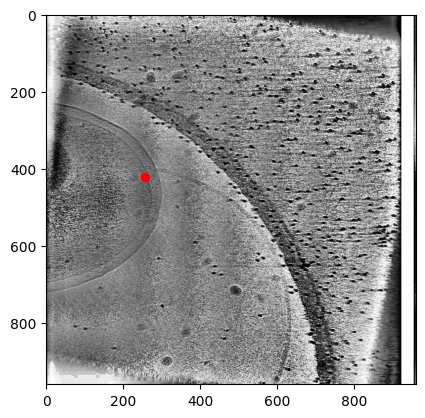

In [8]:
aug_number = 300

plt.imshow(augmented_images_normed[aug_number], cmap='gray')
plt.scatter(x=augmented_keypoints[aug_number][0], y=augmented_keypoints[aug_number][1], c='r')

In [9]:
def generate_base_data():
  all_slices_number = df['Array_shape_axis_0'].unique()

  filtered_image_paths,labels = selection_images_labels(increased_df, 'adaptequal_1_padded', num_slices=list(all_slices_number), num_motors=[1])

  train_ds, val_ds, test_ds = batches_images_ram(
      read_img_jpg,
      filtered_image_paths,
      labels,
      shuffle=True,
      batch_size=32,
      split=True,
      val_fraction=0.2,
      test_fraction=0.2,
      seed=42)

  return train_ds, val_ds, test_ds

In [10]:
train_ds, val_ds, test_ds = generate_base_data()

Found 648 images in ./drive/MyDrive/adaptequal_1_padded
Matched 389 image-label pairs


In [11]:
augmented_images_normed, augmented_keypoints = generate_augmented_images()

augmented_images_normed = tf.stack(augmented_images_normed)  # (N, H, W, C)
augmented_keypoints = tf.stack(augmented_keypoints)

augmented_ds = tf.data.Dataset.from_tensor_slices((augmented_images_normed, augmented_keypoints))
augmented_ds = augmented_ds.batch(32)

final_train_ds = augmented_ds

final_train_ds = final_train_ds.concatenate(augmented_ds)


# -------------------------------------------

#augmented_images_normed, augmented_keypoints = generate_augmented_images()

#augmented_images_normed = tf.stack(augmented_images_normed)  # (N, H, W, C)
#augmented_keypoints = tf.stack(augmented_keypoints)

#augmented_ds = tf.data.Dataset.from_tensor_slices((augmented_images_normed, augmented_keypoints))
#augmented_ds = augmented_ds.batch(32)

#final_train_ds = final_train_ds.concatenate(augmented_ds)

Found 648 images in ./drive/MyDrive/adaptequal_1_padded
Matched 389 image-label pairs


In [12]:
#augmented_images_normed, augmented_keypoints = generate_augmented_images()

#augmented_images_normed = tf.stack(augmented_images_normed)  # (N, H, W, C)
#augmented_keypoints = tf.stack(augmented_keypoints)

#augmented_ds = tf.data.Dataset.from_tensor_slices((augmented_images_normed, augmented_keypoints))
#augmented_ds = augmented_ds.batch(32)

#final_train_ds = final_train_ds.concatenate(augmented_ds)

In [13]:
# Étape 1 : Compter le nombre total d'éléments dans train_ds
#train_ds_size = 0
#for _ in train_ds:
#    train_ds_size += 1

# Étape 2 : Calculer la taille du tiers
#subset_size = train_ds_size // 3

# Étape 3 : Extraire 1/3 du dataset (take) et garder les 2/3 restants (skip)
#subset_ds = train_ds.take(subset_size)
#remaining_train_ds = train_ds.skip(subset_size)

# Étape 4 : Ajouter subset_ds à val_ds
#new_val_ds = val_ds.concatenate(subset_ds)

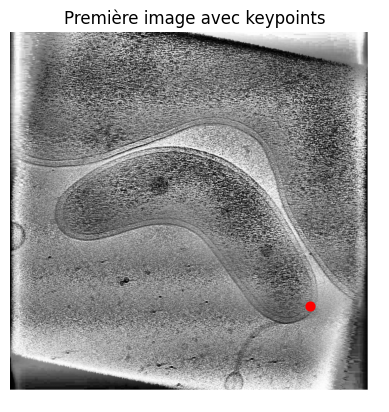

In [14]:
import matplotlib.pyplot as plt

# Prendre le premier batch du dataset
for image_batch, keypoints_batch in train_ds.take(1):
    first_image = image_batch[0]         # 1ère image du batch
    first_keypoints = keypoints_batch[0] # keypoints associés

# Convertir l'image en numpy pour matplotlib (si TensorFlow eager)
first_image_np = first_image.numpy()

# Afficher l'image
plt.imshow(first_image_np.squeeze(), cmap='gray')  # squeeze pour enlever la dimension canal si =1

# Afficher les keypoints (x,y) en rouge
x = first_keypoints[0].numpy()
y = first_keypoints[1].numpy()
plt.scatter(x, y, c='r', s=40)

plt.title('Première image avec keypoints')
plt.axis('off')
plt.show()

Epoch 1/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 92s 7s/step - euclidean_loss: 725.1941 - loss: 724.1215 - val_euclidean_loss: 756.6044 - val_loss: 728.4202
Epoch 2/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - euclidean_loss: 718.4706 - loss: 717.4276 - val_euclidean_loss: 747.2751 - val_loss: 719.1599
Epoch 3/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - euclidean_loss: 708.2016 - loss: 707.2611 - val_euclidean_loss: 733.8857 - val_loss: 705.8452
Epoch 4/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - euclidean_loss: 693.7750 - loss: 692.8862 - val_euclidean_loss: 714.8362 - val_loss: 686.8776
Epoch 5/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - euclidean_loss: 672.7466 - loss: 671.9659 - val_euclidean_loss: 688.5144 - val_loss: 660.7210
Epoch 6/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - euclidean_loss: 641.6472 - loss: 641.0235 - val_euclidean_loss: 652.8499 - val_loss: 625.3776
Epoch 7/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - euclidean_loss: 603.4406 - loss: 602.9323 - val_euclidean_loss: 606.7960 - val_

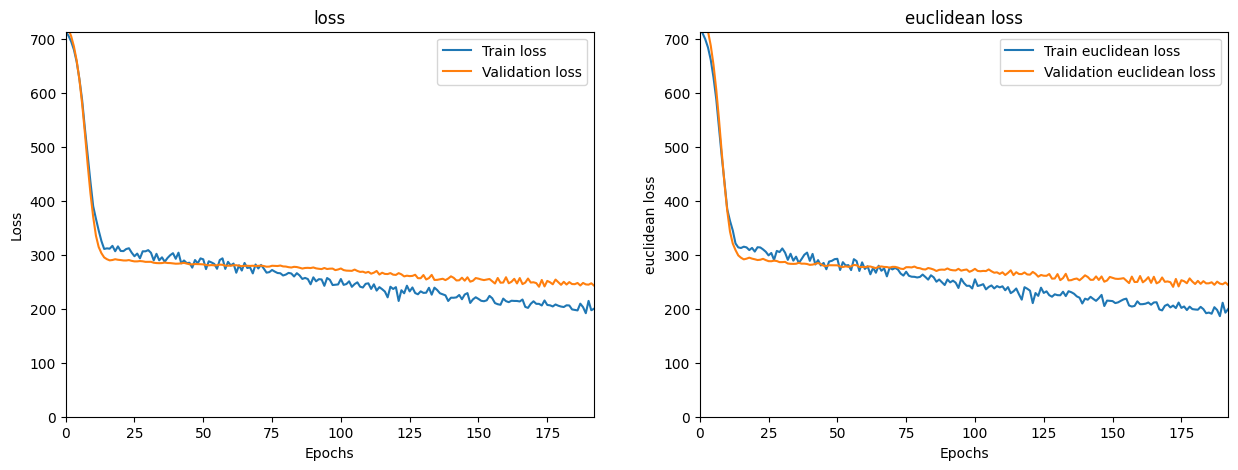

In [20]:
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.applications import Xception
from tensorflow.keras.callbacks import EarlyStopping

def euclidean_loss(y_true, y_pred):
    return tf.reduce_mean(tf.sqrt(tf.reduce_sum(tf.square(y_true - y_pred), axis=-1)))

NUM_KEYPOINTS = 1  # change si tu veux plusieurs points
IMG_SIZE = 224

input_tensor = Input(shape=(960, 960, 1), name="grayscale_input")

# Resize et conversion N&B -> RGB
x = layers.Resizing(IMG_SIZE, IMG_SIZE)(input_tensor)
x = layers.Conv2D(3, (3, 3), padding='same')(x)

backbone = Xception(include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
backbone.trainable = True  # gel du backbone

for layer in backbone.layers[:-2]:
    layer.trainable = False

x = backbone(x)

# Flatten + Dense
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(10, activation='relu')(x)
x = layers.Dropout(0.1)(x)

# Sortie des keypoints
out = layers.Dense(NUM_KEYPOINTS * 2, activation='linear', name="keypoints")(x)

model = Model(inputs=input_tensor, outputs=out)
model.compile(optimizer='adam', loss=euclidean_loss, metrics=[euclidean_loss])

# Callback early stopping
es = EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True, verbose=1)

# Entraînement
history = model.fit(train_ds, validation_data=val_ds, epochs=200, callbacks=[es])

plot_history_regression(history)

In [21]:
model.evaluate(test_ds)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 359ms/step - euclidean_loss: 246.9831 - loss: 251.3916


[240.39633178710938, 231.5792999267578]